# Explainer notebook

## Motivation

In this project, work is being done on a dataset about food. The raw data for the dataset was acquired from a Github-page (https://github.com/onzie9/all_recipes_data?fbclid=IwAR1yBysM3jpAMxyb3suYaoCV6o8ZK8G56s_UDFzunJa4PvLvZYsOa8Z1AT8). The author have scraped 250.000+ recipes from the website allrecipes.com. For each recipe in the raw data there are the attributes; recipe name, recipe ID and its ingredients.
There will also be scraped the overall rating and all of its reviews for each recipe.

The universe of food is big and vast. There are many different cuisine around the world which are different in many ways, but they also have similarities. The project will hopefully discover similarities and differences between the cuisines in form of the different ingredients they use. There will also be investigated if there is a correlation between the rating and the sentiment level for reviews of the different recipes.

## Basic stats 

The size of the dataset is 78 MB, which corresponding to over 2 millions lines of txt-file. The dataset contains 83575 recipes and around 63000 unique ingredients. To start with data the set is loaded from the files and saved in a dataframe.

In [1]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as nx_comm
import community
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import string
import math
from PIL import Image
from itertools import islice
from IPython.display import Image

In [2]:
lines = [] #Making a list to contain all lines from raw_data_1.txt

#Loading all lines from raw_data_1
for i in range(1,5):
    f = open(f'raw_data_{i}.txt', 'r')
    lines.extend(f.readlines())
    
lines = [x.lower() for x in lines] #Making all letter lowercase


In [3]:
d = collections.defaultdict(list) #Making empty dictionary

#Loop for making the dataframe
for i in range(len(lines)):
    if lines[i][0] == '=':
        ing = []
        j = 3
        try:
            while lines[i+j][0] != '=':
                ing.append(lines[i+j])
                j = j + 1
            
                d['Recipe'].append(lines[i+1]) #Recipe name
                d['ID'].append(lines[i+2]) #Recipe ID
                d['Ingredient'].append(ing) #Ingredients in the recipe
        except:
            continue

In [4]:
df = pd.DataFrame(d, columns=['Recipe', 'ID', 'Ingredient'])
df = df.drop_duplicates(subset='Recipe', keep='first') #Removing duplicates
df = df.reset_index(drop=True)

In [5]:
for i in range(len(df)):
    df['Recipe'][i]=df['Recipe'][i][:-1] #Remove \n from recipe names
df['Recipe'][0][:-1]
df['ID'] = df['ID'].str.replace(r'\D', '') #Removing everything but ID number from recipe ID

In [6]:
df.head()

Recipe    ID  \
0             mexican-strawberry-water-agua-de-fresa     3   
1                               crispy-cheese-twists  6663   
2  basil-roasted-peppers-and-monterey-jack-cornbread  6664   
3                                   moms-yeast-rolls  6665   
4                               sweet-potato-bread-i  6666   

                                          Ingredient  
0  [[4 cups strawberries, sliced\n,  1 cup white ...  
1  [[1/2 cup parmesan cheese\n,  3/4 teaspoon gro...  
2  [[1/2 cup unsalted butter, chilled and cubed\n...  
3  [[2 cups hot water\n,  1/2 cup margarine\n,  1...  
4  [[1 1/2 cups white sugar\n,  1/2 cup vegetable...

In the ingredient-column there are a lot of things that is not needed in a ingredients network, such as the amount of an ingredient and its condition. Anything else than the letters a-z will be removed.

One of the big challenges in this project is to make the ingredients more uniform. Since all the recipies and ingredients are user generated, there can be spelling errors or they will write they own take of the ingredient, and not the "base" ingredient. An example of this could be "low-fat free range chicken breast" instead of just "chicken breast". In order to remove the most common words that appear with the base ingredients, we created a word-filter of which removes the words from the ingredients. The filter was created by running the script, and see the most common ingredients. Then we took the all words that wasnt a "base ingredient" and added to the wordlist for the filter. This process was repated several times.

In [7]:
#Stopwords
stopwords = nltk.corpus.stopwords.words('english')
#Predefined bad words
bad_words=["tablespoon","cup","inch","thick","fresh","pounds","pound","to",
           "cups","optional","frozen","allpurpose","softened",
           "tablespoons","ounce","or","packages","package","dry","active","warm","hot","f","c","degrees",
          "sliced","cold","cut","wedges","into","teaspoon","shredded","chopped","ounces","roasted","marinated","drained","teaspoons","can","clove","dried","crumbs"
           ,"slices","skinless","boneless","beate","beate","pinch","pinched","melted","mashed","sifted","unsweetend",
           "lightly","extract","room","temperature","instant","coffee","granules","dissolved","sheet","puff","thawed","broken","and"
          "unsalted","chilled ","cubed","whole","heads","medium","large","small","halves","lukewarm","refrigerated","with","skin",
          "jar","pieces","taste","crushed","pitted","unsweetened","saltine","dark","semisweet","crisp","prebaked","head","grated"
          "divided","unsalted","halved","ingredients","firm","bitesize","and","removed","trimmed","diced","cubes","half","thin","halfed",
          "halved","ingredients","firm","bitesize","and","removed","trimmed","diced","cubes","half","thin","for","a","single","of","needed","peeled",
          "no","calorie","extra","virgin","o","torn","plus","more","see","tips","two","rinsed","fine","such","as","low","fat","grated","packed"
          "minced","ground","thinly","finely","uncooked","crispy","shake","n","baked","ingredient","note","reduced","oz","cooked"
          ,"crumbeled","tripple","sec","not","process","divided","halfandhalf","freshly","freshground","packed","light","lowfat"
          ,"fatfree","at","lowsodium","dusting"," ","all","purpose","homemade","frying","organic","goya","desired","minced"
          "pressed","very","ripe","salted","white","easy","sweet","minc","cloves","beaten","clove"]
stopwords.extend(bad_words) #Extending the stopword-list with the predefined bad words
#Stemming words
ps = PorterStemmer() 

To aviod difference between e.g. "chicken" and "chickens" stemming will be done on the ingredients. Some of the ingredients also contains the letter combination "xae", which will be removed.

In [8]:
col = df['Ingredient'].tolist()
for j in range(len(col)):
    for k in range(len(col[j])):
        col[j][k] = re.sub(r'[^a-zA-Z ]+', '', col[j][k])#Remove all there isn't a letter
        col[j][k]=(" ".join(i for i in col[j][k].split() if i not in bad_words))#Remove all words in bad_words-list
        col[j][k]=(" ".join(i for i in col[j][k].split() if i not in bad_words))
        if len(col[j][k].split(" ")) > 2:#Stemming word, and joins them if more than two words define an ingredient
            r=col[j][k].split(" ")
            for o in range(len(r)):
                r[o]=ps.stem(r[o])
            col[j][k]=" ".join(r)
        
        else:
            col[j][k]=ps.stem(col[j][k]) #Stem ingredients defined by one word
        
        v = col[j][k].split(" ")
        col[j][k]=(" ".join(x for x in col[j][k].split() if not "xae" in x))#Removing words with "xae"

In order to deal with ingredients which is not described with only the base ingredient, containing ingredients conisisten of more then 3 words will also be removed. The choice was between removing the ingredient from the recipe or the recipe. The later was choosen because a recipe with missing ingredients would not be complete and therefore noise in the ingredient-network.

In [9]:
indexes=[] #Index of all recipes with ingredients over 3 words 
for j in range(len(col)):
    for k in range(len(col[j])):
        if len(col[j][k].split(" ")) > 3: # Checking if there is a ingredient with over 3 words
            indexes.append(j)
            
df.Ingredient = col

df = df.drop(df.index[indexes]) #Removing recipes

df = df.reset_index(drop=True)

### Exploring the data

After data cleaning the amount of recipes is 39946 and the amount of unique ingredients is 14735.

Originally the plan was to create a Biparte graph with Recipes and unique ingredients as nodes, and link the ingredients used in a recipe together. Then we would take its weightet projection onto the the recipe. This would allow us to explore recipes further, where the weight between two recipe-nodes would determine how many ingredients the recipes shared. However the size of the network made this approach very difficult due to high running times. We managed to reduced the dataset to only revolve around cooking recipes, after taking the projection we had roughly 7000 nodes and 11.000.000 edges. Due to the high number of edges illustrating the graph and further analysis was extremly slow and we felt that we lost too much information about the network by reducing the data-set further. 

Instead a graph will be made where all nodes are a ingredient and there will be a link between two ingredients if they are in the same recipe. A weight will be added to each link where the weight is equal to the number of recipes the ingredients both appear in. The more connected to ingredients are, the more commonly they are used together.
The graph have 14735 nodes and 331241 edges.

In [10]:
recipes = df['Recipe'].tolist()
ing = df['Ingredient'].tolist()

for i in range(len(ing)):
    ing[i] = list(filter(None, ing[i])) #Removing empy str ingredients
    ing[i] = [w.replace('baking soda', 'baking powd') for w in ing[i]] #making a common name for baking soda

all_ingredients = []#Finds all unique ingredients
for i in range(len(ing)):
    all_ingredients.extend(ing[i])
fdist = list(nltk.FreqDist(all_ingredients))


for i in range(len(ing)):#Replaces space with _
    for j in (range(len(ing[i]))):
        ing[i][j]=ing[i][j].replace(" ", "_")

Below can the most commonly used ingredients be seen:

In [11]:
fdist=nltk.FreqDist(all_ingredients)
names=[]
val=[]
for i in range(len(fdist.most_common(15))):
    names.append(fdist.most_common(15)[i][0])
    val.append(fdist.most_common(15)[i][1])

[Text(0, 0.5, 'Ingredients'),
 Text(0.5, 0, 'Occurances in recipes'),
 Text(0.5, 1.0, '15 most common ingredients')]

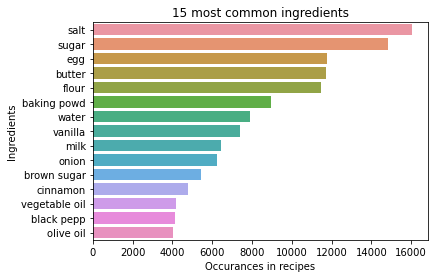

In [12]:
ax = sns.barplot(x=val, y=names)
ax.set(xlabel='Occurances in recipes',ylabel="Ingredients",title='15 most common ingredients')

#plt.tight_layout()
#fig = ax.get_figure()
#fig.savefig("mostcommonIng.png")

It is also interesting to know the most common recipe types. The Recipes types is determined by the ingredients that appeared  most often in the recipe titles. 

In [13]:
words_rec = []
for i in range(len(recipes)):
    words_rec.extend(recipes[i].split("-"))#Finds the ingredients in recipe name, and count the most frequent one.
filtered_recipe_words = [w for w in words_rec if not w in (stopwords+bad_words)]  
fdist_rec = nltk.FreqDist(filtered_recipe_words)
fdist_rec.pop("ii")

1078

[Text(0, 0.5, 'Recipe type'),
 Text(0.5, 0, 'Frequency of recipe type'),
 Text(0.5, 1.0, '15 most common recipe types')]

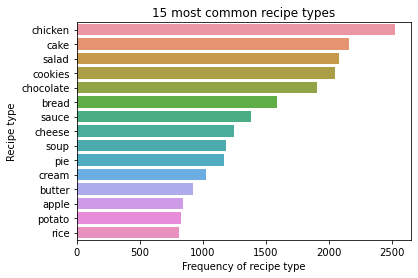

In [14]:
names_rec=[]
val_rec=[]
for i in range(len(fdist_rec.most_common(15))):
    names_rec.append(fdist_rec.most_common(15)[i][0])
    val_rec.append(fdist_rec.most_common(15)[i][1])
ax = sns.barplot(x=val_rec, y=names_rec)
ax.set(xlabel='Frequency of recipe type',ylabel="Recipe type",title='15 most common recipe types')

#plt.tight_layout()
#fig = ax.get_figure()
#fig.savefig("mostcommonRec.png")

It can be seen the most common recipe type is for chicken dishes. However there also seems to be large amount of baking recipes when you look at "cake", "cookies","bread","pie". This way of categorizing  recipes is not optimal, since if a recipe is "Chocolate chip cookies" both chocolate and cookies would be counted, however the general tendency of the recipe types is outlined. Looking at the most common ingredients it can be seen that there are a lot of baking ingredients, as well as other common condiments.

In [15]:
G = nx.Graph()
G.add_nodes_from(fdist,node_type="Ingredient")#Add nodes from unique ingredients

for i in range(len(ing)):
    edges=list(combinations(ing[i],2))#Adds an edge between all combinations of the ingredients in it.
    for j in range(len(edges)):
        if G.has_edge(edges[j][0],edges[j][1]):#adds weight when the same connection is made more than one time
            G[edges[j][0]][edges[j][1]]['weight'] += 1
        else:
            G.add_edge(edges[j][0],edges[j][1], weight=1)
            
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

Below can it be seen a node degree distribution of ingredient-nodes. The distribution look like a power-law distribution, which means that a lot of nodes have a low degree and very few have a really high degree. This observation makes sense. And that is because some ingredients is used in a lot of recipes, an example of this is 'salt'. At the same time there is also a lot of unique ingredients that is only used in 100 recipes or less. 

<Figure size 432x288 with 0 Axes>

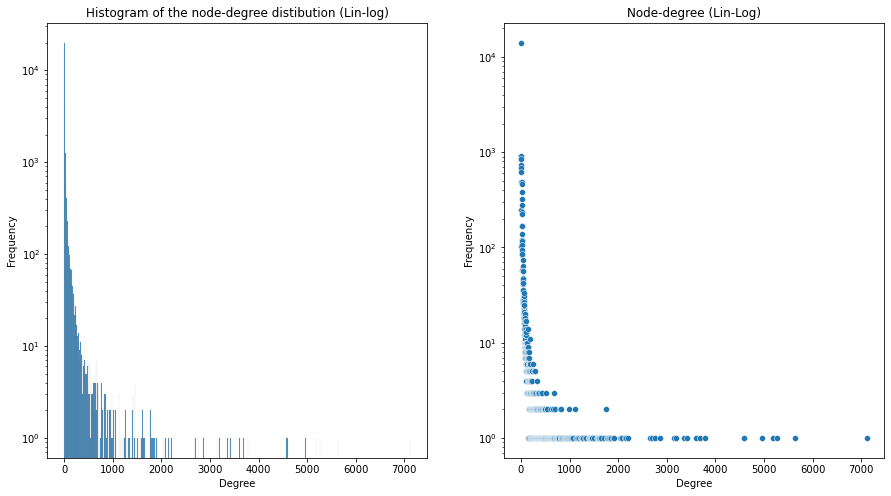

In [16]:
data_out=list(dict(G.degree()).values())
all_entries = np.unique(data_out)
bin_edges = [element - 0.5 for element in all_entries]
bin_edges.append(all_entries[-1] + 0.5)
histogram, _ = np.histogram(data_out, bins=bin_edges)

plt.tight_layout()
fig, axes = plt.subplots(1,2,figsize=(15,8))
ax=sns.histplot(list(dict(G.degree()).values()), binwidth=10,label=None, ax=axes[0])
ax.set(yscale="log",xlabel='Degree',ylabel="Frequency",title='Histogram of the node-degree distibution (Lin-log)')

splot=sns.scatterplot(x=all_entries, y=histogram,ax=axes[1])
splot.set(yscale='log',xlabel='Degree',ylabel="Frequency", title='Node-degree (Lin-Log)')

plt.savefig('Node-Degree_dist.png')

**Centrality measures**

Degree centrality determind the importance of each node in the network based on the number of links each node have. It is used to find very connected nodes, which is likely to hold the most information about the network. It can be seen that ingredients like salt, sugar and water have a high degree centrality.

In [17]:
cen=nx.degree_centrality(G0)
cen={k: v for k, v in sorted(cen.items(), key=lambda item: item[1],reverse=True)} #Sorting by item value
list(islice(cen.items(), 10))

[('salt', 0.48397850193890746),
 ('sugar', 0.3832233485271107),
 ('water', 0.3581195999727873),
 ('butter', 0.3526090210218383),
 ('egg', 0.3379821756582081),
 ('flour', 0.3125382679093816),
 ('onion', 0.3115177903258725),
 ('olive_oil', 0.25716035104428875),
 ('black_pepp', 0.25056126267093004),
 ('milk', 0.24518674739778218)]

Like degree centrality, eigenvector centrality determind the importance of each node in the network based of the number of links each node has. Eigenvectors takes it a step further by also taking into account how well connected a nodes connected nodes are. So it is likely that it shares results with the degree centrality. It can be seen that sugar and salt have swapped places and that flour, vanilla and milk have moved up. This can be an indication of the influence of baking recipes in the network.

In [18]:
Evc=nx.eigenvector_centrality(G0, max_iter=100, tol=1e-06, nstart=None, weight='weight')
Evc={k: v for k, v in sorted(Evc.items(), key=lambda item: item[1],reverse=True)} #Sorting by item value
list(islice(Evc.items(), 10))

[('sugar', 0.3948944085455774),
 ('salt', 0.3675460224724136),
 ('flour', 0.36645133332148927),
 ('egg', 0.34374647979031975),
 ('baking_powd', 0.33746000844666946),
 ('butter', 0.3047663787770009),
 ('vanilla', 0.25417975344628146),
 ('milk', 0.18485334679462548),
 ('cinnamon', 0.155493327819293),
 ('water', 0.15510586919094735)]

With Gephi betweeness centrality, closeness centrality and harmonic closeness centrality have been calculated.

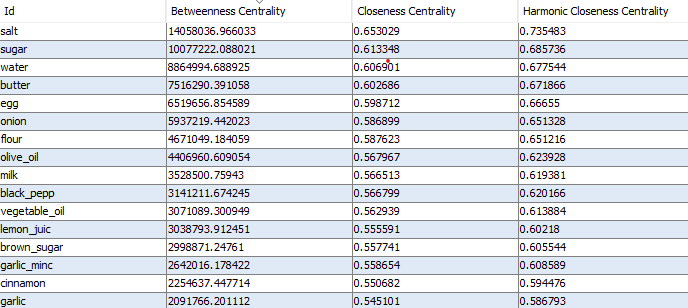

**Visualising the graph**

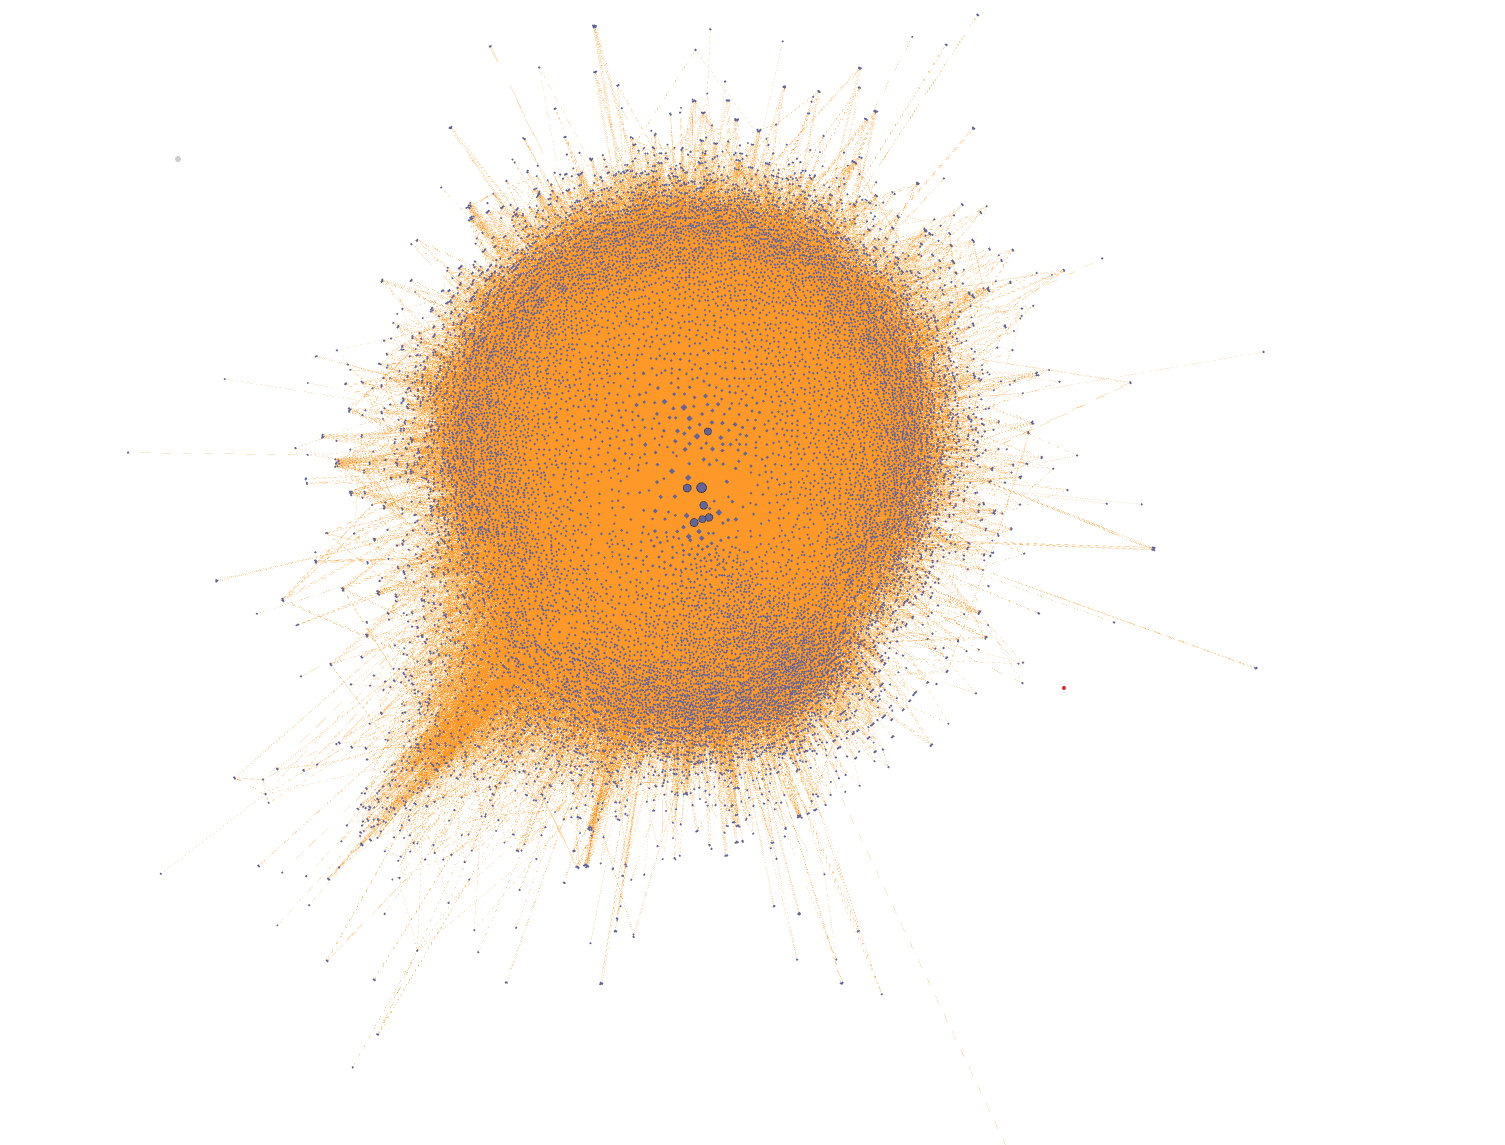

The above plot is made in Gephi which is a graph/network illustration tool which allow for GPU accelearted calculations . The reason we used this is due to the size of the network, which resulted in very high running times through NetworkX and matplotlib. In the graph above the ForceAtlas2 algorithm was used, and node size is propertional to its degree, edges are orange and nodes are blue.

## Tools, theory and analysis

### Community detection

We will try to detect communities in the network of ingredients. Hopefuly the community detection will detect  ingredients who are commonly used together and from this we would be able to outline some of the different cuisines of the world. We will illustrate the biggest communities with wordclouds.

For community detection we will use the Louvain algorithm. The Louvain algorithm consists of two phases. The first phase looks for "small" communities by optimizing modularity in a local way. The second phase aggregates nodes of the same community and builds a new network whose nodes are the communities. These two phases are repeated iteratively until a maximum of modularity is attained. (https://sites.google.com/site/findcommunities/).

The sizes of the ingredients in the wordclouds will be determinded from their degree. 

In [19]:
partition = community.best_partition(G0)#Finding communities

n = len(Counter(partition.values()))

print(f'The Louvain algorithm detects {n} communities')

The Louvain algorithm detects 34 communities


We will look at the distribution of the community sizes.

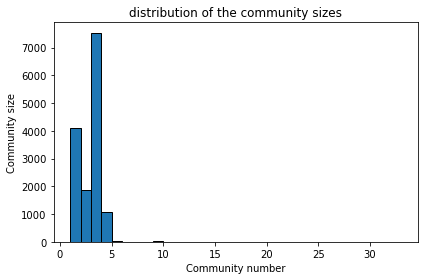

In [20]:
com=np.arange(1,n)
val=list(Counter(partition.values()).values())

fig, ax = plt.subplots()
ax.bar(com[:-1], val[0:n-2], width=np.diff(com), edgecolor="black", align="edge")
ax.set_ylabel("Community size")
ax.set_xlabel("Community number")
ax.set_title("distribution of the community sizes")
plt.tight_layout()
plt.savefig('Community_dist.png')

In [21]:
print(f'{sum(val[:4])/len(G0.nodes())*100} % of the nodes are in the 4 biggest communities')

99.04081632653062 % of the nodes are in the 4 biggest communities


From the plot it can be seen that there are 4 big communities and the rest are small. This may be a sign of the limits of modularity. We know that modularity maximization forces small communities into larger ones, but what is the modularity of the partition?

In [22]:
list_of_sets = [] #Calculating the modularity of the partition
par = 0
while par < n:
    lst = []
    for i in partition:
        
        if partition[i] == par:
            lst.append(i)

    list_of_sets.append(lst)
    par = par + 1

print(f'The modularity of the partition is {nx_comm.modularity(G0, list_of_sets)}')

The modularity of the partition is 0.2726500046395058


The partitions modularity is quite low. The reason for that could be that the ingredient network have nodes like 'salt', 'sugar', 'water' etc. with a very large degree.

In [23]:
number_of_com=len(set(partition.values())) #Number of communities

coms = [] #Empty list to store lists of the different communities

# Loop for making p lists in a list
for p in range(number_of_com):
    coms.append([])
    
# loop for adding each ingredient to a community
for key, value in partition.items():
    coms[value].append(key)
    
coms=coms[0:4]#selectiing

In [24]:
degree_dict=dict(G0.degree())

all_words=[]

for j in range(len(coms)): #Making a list of list of the words in the community, and write them as many times as their degree
    words_1=[]
    for i in range(len(coms[j])):
        words = [degree_dict[coms[j][i]]*(coms[j][i]+" ")]
        words_1.extend(words)
    all_words.append(words_1)

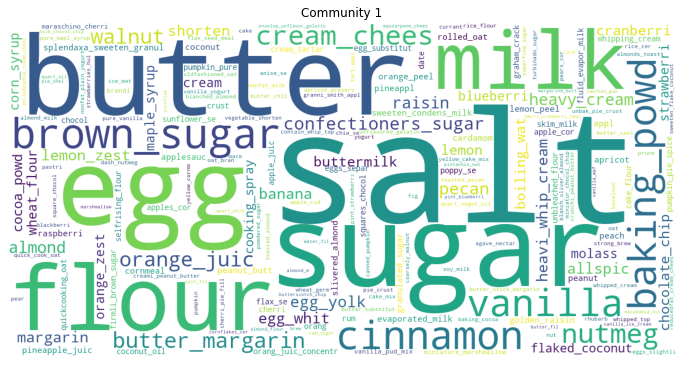

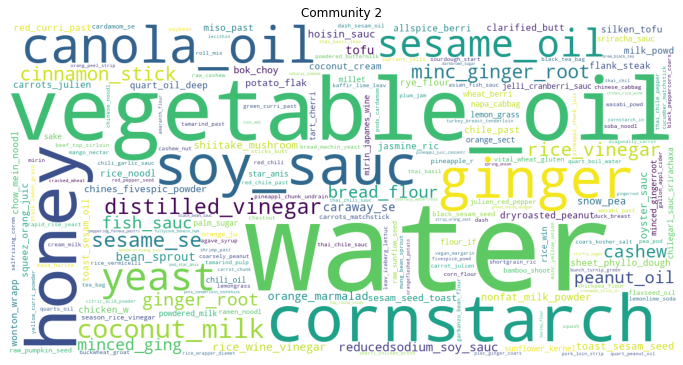

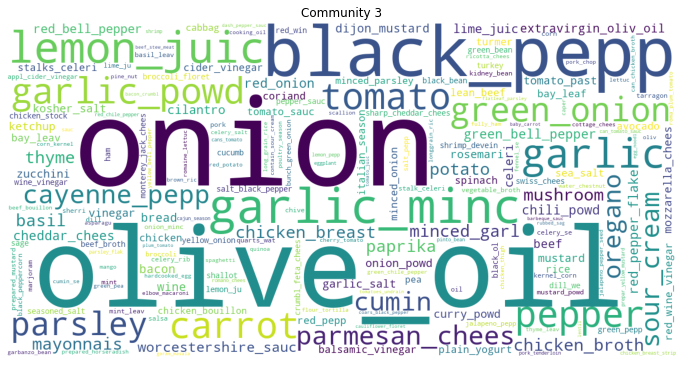

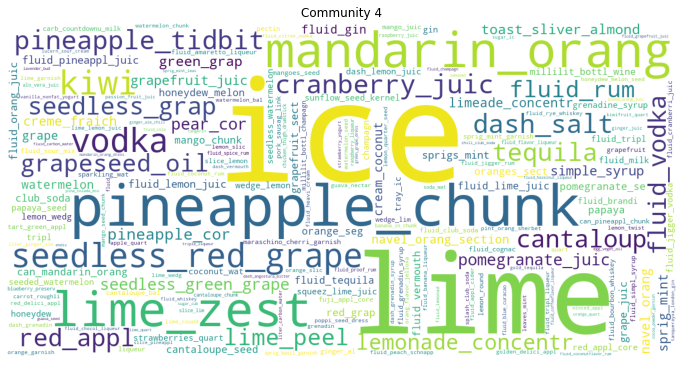

In [25]:
from wordcloud import WordCloud, STOPWORDS
#from scipy.misc import imread

#mask = imread('ChickenStick.png', flatten=True)


for i in range(len(all_words)):#Creating wordclouds of the communities
    wordcloud = WordCloud(
                          stopwords=STOPWORDS, collocations = False,width=1200, height=600,
                          background_color='white', #mask = mask 
                         ).generate(str(all_words[i]))
    fig = plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.title(f'Community {i+1}')
    plt.axis('off')
    plt.savefig(f'Community_dist_{i+1}.png')
    plt.show()

The big ingredients in community 1 are salt, sugar and flour. From them and the other ingredients in the wordcloud it is save to say community 1 is baking. Community 2 can categories as asian, mostly because of ingredients like soy source, ginger and fish source. Community 3 important ingredients are onion, olive oil and black pepper. It is not as clear as community 1 but we would categories community 3 as western dinner. Community 4 is clear as community 1. Community 4 contains ingredients like ice, pineapple chunk, vodka and tequila. So we would categories community 3 as cocktails.

The community detection shows that the data behind the ingredient network isn't diverse. The data mostly contain baking- and cocktail-recipes.

Below the graph can be seen, where it's divided into its communitys. It as plotted with ForceAtlas2, and node size propertional to its degree in gephi. We can see community 1,3 and 4 all are relative isolated, whereas community 2 interacts quite evenly with the rest of the communities.

_Note: the community sizes does not match 100% with the labels on the graph below due the sizes of them change when the script is runned again_

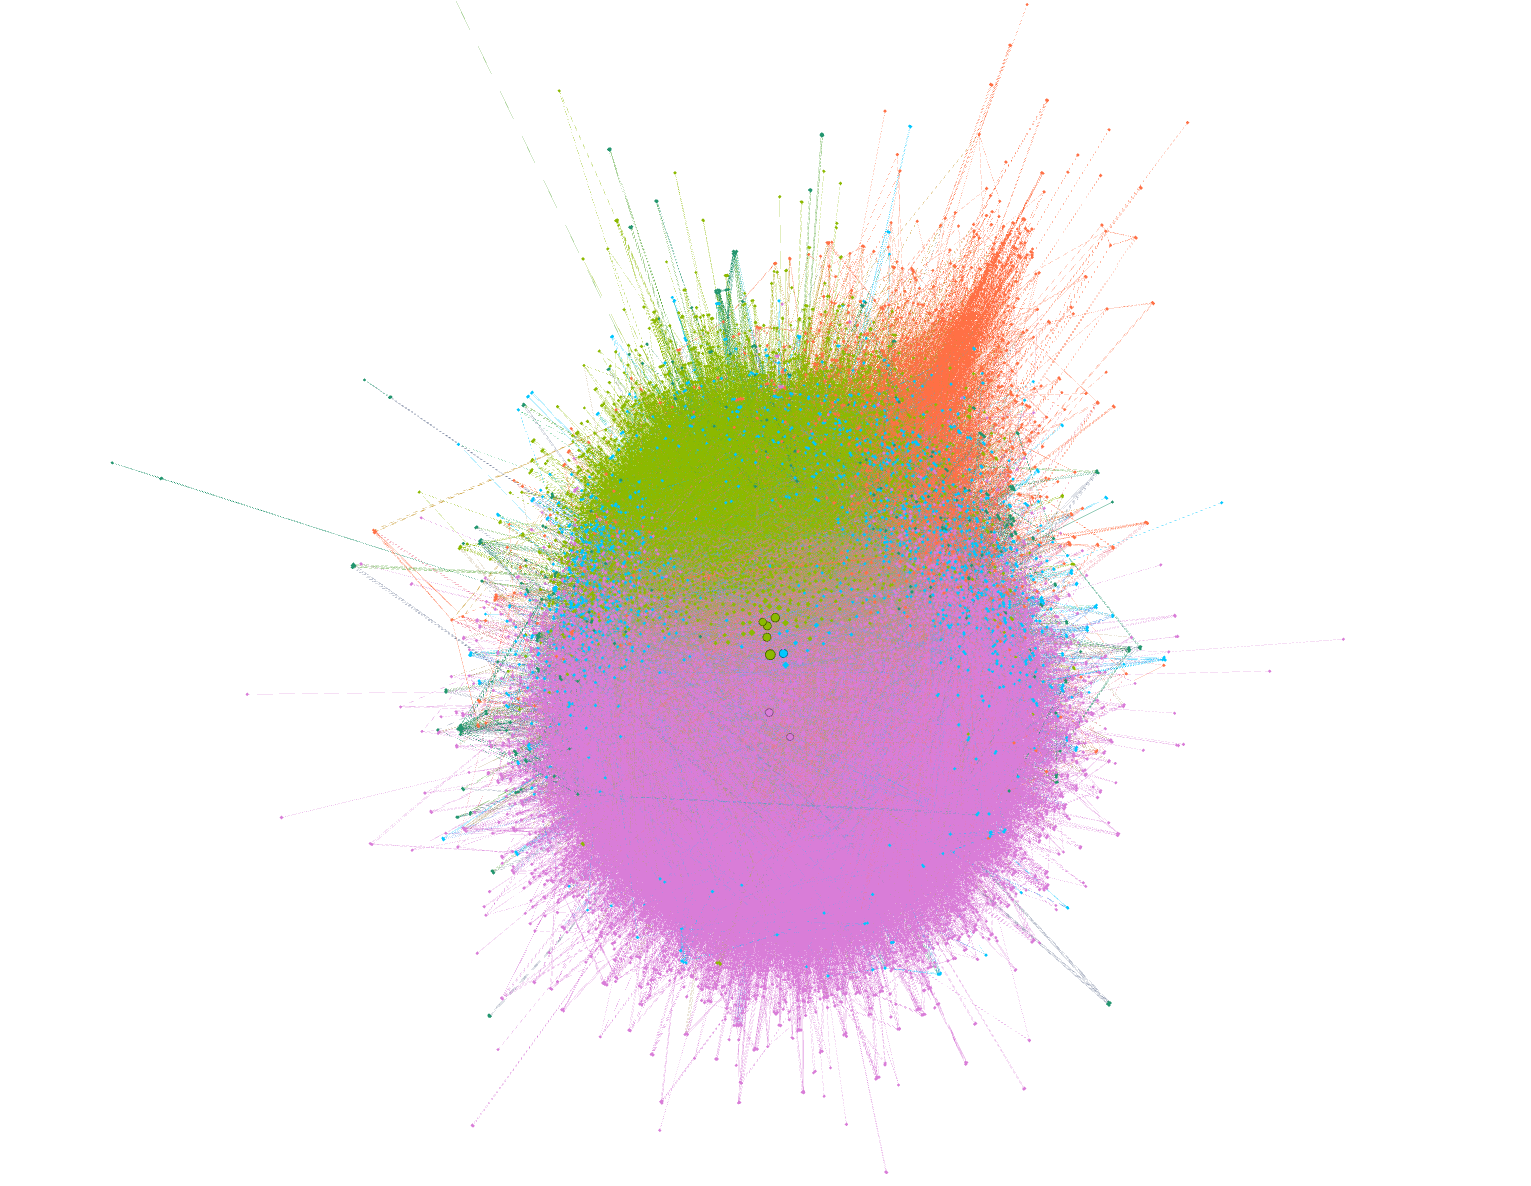

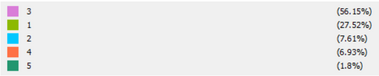

**Reviews scrape & sentiment**

We are also interestet in the recipes which the ingredients were filtered from. When you are choosing between two recipes of ex. lasagna which both is rated 5 stars, could the sentiment score of the reviews be a usefull tool for making the decision easier? It would also be interesting to explore if there is a correaltion between the amount of stars given and the sentiment score of the review.

First we have to scrape the data from Allrecipes.com - The Urls are generated from the recipe titles in the dataframe and a standard format Allrecipes.com uses. We are scraping the 10 most "helpfull" reviews from each recipe, where the helpfullness score is given by number of times other users found the review helpfull.

In [26]:
urls=[]
for i in range(len(df)):
    urls.append(f"https://www.allrecipes.com/recipe/{df.iloc[i][1]}/{df.iloc[i][0]}/?page=2")

When scraping, we are downloading all the data from the website and filter the reviews and score. In order to not get IP-banned (Scraping isnt technically allowed of the site, and bans an IP after 10-20 fast scrapes) we established a connection through tor where we changed our IP every 11th request, we also used a timer of 1.4 seconds between each request to not overload the site. Each time new data was scraped, it was saved in a txt. We managed to scrape roughly 10 reviews for 9810 Recipes.

In [27]:
from bs4 import BeautifulSoup
import requests
from torrequest import TorRequest
import time

Reviews_file = open("Reviews.txt", "a")
No_Reviews_file = open("No_Reviews.txt", "a")
equalsigns = "======================================="


for i in range(12432,len(urls)):
    
    if i % 11 == 0:
        print(f"Chaning proxt at request{i}") #Changing IP through thor at every 11th request
        with TorRequest(proxy_port=9050, ctrl_port=9051, password='XXXXXXX') as tr:
            tr.reset_identity()
    
    try:
            
        r = requests.get(urls[i])#making request and download html as text
        soup = BeautifulSoup(r.text, "html")
        mydivs = soup.find_all("div", {"class": "component ugc-review ugc-item recipe-review-wrapper"}) #finding the desired sections on the website
        data=[]
        for j in range(len(mydivs)):#filtering through the div with regex to search for rating and review
            rating=re.search('(?<=Rating: )(\w+)', str(mydivs[j])).group(1)
            review=re.search('\n<div class="recipe-review-body">\n                        \n                        \n                            (.*?)\n', str(mydivs[j])).group(1)
            data.append([rating,review])
        
        if len(data) > 0: #If the request isnt empty continue
            Reviews_file.write("\n" + equalsigns + "\n" + df.iloc[i][0])
        
            for k in range(len(data)):#Save the reviews in a text file
                Reviews_file.write("\n" + data[k][0] + "---" + data[k][1])
        else:
            No_Reviews_file.write("\n"+df.iloc[i][0])
        
    except: #If no connection is made save them name of the recipe
        No_Reviews_file.write("\n"+df.iloc[i][0])
    
    time.sleep(1.4) #Timer to slow traffic down to not disturb the site

Loading the scraped data

In [28]:
with open('Reviews.txt','r') as f: #Opens txt and read all lines
    lines = f.readlines()
    
lines = [x.lower() for x in lines] #Make everything lowercase

d = collections.defaultdict(list) #Creating an empty dict/list to store data

In [29]:
d = collections.defaultdict(list) #Script for reading the lines in the txt.file and store the right values
for i in range(len(lines)):
    if lines[i][0] == '=': #txt sepeartes recipes with a line of =========
        j=2
        rev=[]
        score=[]
        try:
            while lines[i+j][0] != '=': #Finding values between ========= and saves them
                rev.append(lines[i+j][4:])
                score.append(lines[i+j][0])
                j=j+1
            
            d['Recipe'].append(lines[i+1])
            d['Score'].append(score)
            d['Reviews'].append(rev)
        except:
            continue
        

In [30]:
df = pd.DataFrame(d, columns=['Recipe', 'Score', 'Reviews'])
df = df.drop_duplicates(subset='Recipe', keep='first') #Removing duplicates
df = df.reset_index(drop=True)

**Data cleaning** 

In general the data from reviews is pretty "clean" however a reviews contain empty string instead of either a rating of review, which will be removed. New line "\n" from the txt will also be removed.

In [31]:
len(df)

9820

In [32]:
for i in range(len(df)):#Removing \n from recipe names
    df['Recipe'][i]=df['Recipe'][i][:-1]

In [33]:
for i in range(len(df)):
    tbr=[]
    for j in range(len(df['Score'][i])):
        df['Reviews'][i][j]=df['Reviews'][i][j][:-1] #Revmoving \n from last part of reviews
        if df['Score'][i][j]=="\n":
            tbr.append(j)
    df['Score'][i] = [x for y, x in enumerate(df['Score'][i]) if y not in tbr]#Removing blank reviews that consist of \n
    df['Reviews'][i] = [x for y, x in enumerate(df['Reviews'][i]) if y not in tbr]
    df['Score'][i] =  list(map(int, df['Score'][i]))#Making str to int   

We are now interested in sorting the reviews by the rating given.

In [34]:
reviews_sorted=[[],[],[],[],[]]

for i in range(len(df)):
    for j in range(len(df['Score'][i])):
        if df['Score'][i][j] == 1:
            reviews_sorted[0].append(df['Reviews'][i][j])
        if df['Score'][i][j] == 2:
            reviews_sorted[1].append(df['Reviews'][i][j])
        if df['Score'][i][j] == 3:
            reviews_sorted[2].append(df['Reviews'][i][j])
        if df['Score'][i][j] == 4:
            reviews_sorted[3].append(df['Reviews'][i][j])
        if df['Score'][i][j] == 5:
            reviews_sorted[4].append(df['Reviews'][i][j])
            


**Data exploration**

In [35]:
all_scores=[]
for i in range(len(df)):
    all_scores.extend(df['Score'][i])

Below can the distrution of the raiting given for all individual reviews from all the recipes. We can see that people are far more likely to leave a positiv review, where 5 stars are by far them most given score. This distribution was not what we expected, with the lack of negative reviews. This could be explained by, if people enjoyed the recipe they are more likely to find it and open it up on the website again, which is where you write the revivew for the recipe.

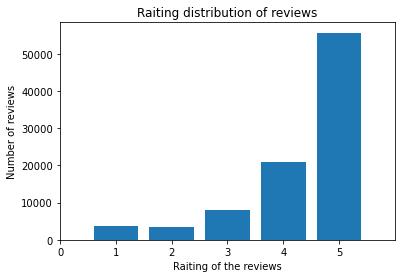

In [36]:
counts = np.bincount(all_scores)
fig, ax = plt.subplots()
ax.bar(range(6), counts, width=0.8, align='center')
ax.set(xticks=range(6), xlim=[0, 6])
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Raiting of the reviews")
ax.set_title("Raiting distribution of reviews")
plt.savefig('Review_dist.png')

We know want to explore the sentiment of the reviews given. Sentiment analysis is a way to quantify the feeling or tone of written text. For this we will be using Using the LabMT wordlist which contain the sentiment score for a large amount of english words.

In [37]:
# Reading LabMT word list
LabMT = pd.read_csv('Data_Set_S1.txt', skiprows=4, sep="\t" , header = None, names = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"])
# Making the index to the words in the list
LabMT = LabMT.set_index('word')

In [38]:
def SentimentCalculator(list_of_tokens):
    sentiment = 0
    N = 0
    for i in range(len(list_of_tokens)): # Loop for checking if a word is in LabMT
        if list_of_tokens[i] in LabMT.index:
            sentiment = sentiment + LabMT.loc[list_of_tokens[i]][1] #Taking the happiness_average
            N = N + 1
        else:
            continue
    if sentiment == 0: #If there are no text in the character-file
        sentiment = 'NaN'
    else:
        sentiment = sentiment/N 
    return sentiment

First we would like to explore the sentiment distrubtion of score cateogory

In [39]:
#The average of each node in a community
stop = set(stopwords + list(string.punctuation))
rev_sentiment_level = [] #Dictionary for storing the sentiment level of each community
score_sent=[]
for i in range(len(reviews_sorted)): #Loop for each community
    sent_x=[]
    for j in range(len(reviews_sorted[i])): #Loop for each character
        
        tokens = [x for x in word_tokenize(reviews_sorted[i][j]) if x not in stop]
        sent=SentimentCalculator(tokens)
        sent_x.append(sent)
        score_sent.append([i+1,sent])
    rev_sentiment_level.append(sent_x)

In [40]:
for i in range(len(rev_sentiment_level)):
    rev_sentiment_level[i] = [x for x in rev_sentiment_level[i] if x != "NaN"]
score_sent = [x for x in score_sent if x[1] != "NaN"]


All sentiment

In [41]:
x_val = [x[0] for x in score_sent]
y_val = [x[1] for x in score_sent]

The average sentiment of reviews with 1 stars is: 5.7220189566057655
The average sentiment of reviews with 2 stars is: 5.841099451810264
The average sentiment of reviews with 3 stars is: 5.895658159309018
The average sentiment of reviews with 4 stars is: 5.999383172676985
The average sentiment of reviews with 5 stars is: 6.082908590306718


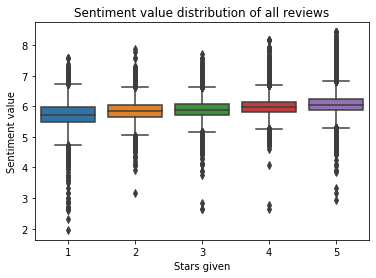

In [42]:
box=sns.boxplot(x=x_val,y=y_val)
box.set(xlabel='Stars given',ylabel="Sentiment value", title='Sentiment value distribution of all reviews')
for i in range(len(rev_sentiment_level)):
    print(f"The average sentiment of reviews with {i+1} stars is: {sum(rev_sentiment_level[i])/len(rev_sentiment_level[i])}")
plt.savefig('Sentiment_dist.png')

We can see there is a slight increase in the sentiment of the reviews, the higher raiting a review has. We do see a larger amount of low score outliers in the one star review, and more in the higher score reviews. However the small difference between the review is quite unexpected. We had been expected the one star reviews would score fairly low sentiment wise, due to common words to describe none tasty food as horrible, awfull and so on. It would be interesting to explore the most common words in for each raiting, however it could seem like there will not be a big difference based on the sentiment levels.

**TF / IDF list**

In order to find the most unique reviews for each Score, we will use TF-IDF lists

First we create the TF list for the new communites. The tf list are made by the raw count of how many times a word appears in its document, which is how many times it appears in all reviews with the same score.

In [43]:
tf_lists = []
stop = set(stopwords + list(string.punctuation))
for p in range(len(reviews_sorted)):
    words=""
    for j in range(len(reviews_sorted[p])):
        words=words+reviews_sorted[p][j]
        
    tokens = [i for i in word_tokenize(words) if i not in stop]
    sw=[]
    for i in range(len(tokens)):
        sw.append(tokens[i].translate(str.maketrans('', '', string.punctuation)))
    sw = list(filter(None, sw))

    tf_lists.append(nltk.FreqDist(sw))

Now we create the IDF-list  by using inverse document frequency smooth. This was choosen since it compliments raw count nicely by weighting words that appears in few scores higher, and vice versa with words that occour in many scores lower. This is nice for multiplying two list together, since words with a high raw count but appears in many scores will have a smaller impact.

The IDF weigths was calculated as seen below, where N is the total number of communites and Nt is the number of communites where the word appears: 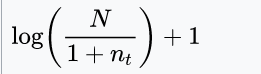

In [44]:
type(tf_lists[0])

nltk.probability.FreqDist

In [45]:
idf_list = [] #Creating a list of dicts for all review_scores
for p in range(len(tf_lists)):
    idf_list.append({})

In [46]:
N=len(tf_lists)
for i in range(N): #Going through each review per score
    k=list(tf_lists[i].keys())
    for j in range(len(k)): #Going through each word in reviews_scores of i 
        weight=0
        for l in range(N): #Checking if a word occuers in the other communites
            if k[i] in tf_lists[i]:
                if tf_lists[l][k[j]] != 0:
                    weight=weight+1
                
        idf_list[i][k[j]]=math.log(N/(1+weight))+1

Creating the tf-idf_lists by multiplying the respecctive Tf and idf lists

In [47]:
tf_idf_list = [] #list of dicts
for p in range(len(tf_lists)):
    tf_idf_list.append({})

In [48]:
for i in range(N): #Calculating the tf_idf list for each community
    k=list(tf_lists[i].keys())
    for j in range(len(k)):
        tf_idf_list[i][k[j]]=idf_list[i][k[j]]*tf_lists[i][k[j]]
    tf_idf_list[i]={k: v for k, v in sorted(tf_idf_list[i].items(), key=lambda item: item[1],reverse=True)}

In [49]:
from wordcloud import WordCloud, STOPWORDS

**Creating a wordcloud displaying the most important words in each Score category (according to TF-IDF).**

In [50]:
str_text_coms = []

In [51]:
for i in range(N): #Ceiling the values of the TF_idf lists, and making one long string with every word in the com*weight
    rounded_values = []
    k=list(tf_idf_list[i].keys())
    for j in range(len(k)):
        ceiled=math.ceil(tf_idf_list[i][k[j]])
        for u in range(ceiled):
            rounded_values.append(k[j])
    str_text_coms.append(" ".join(rounded_values))

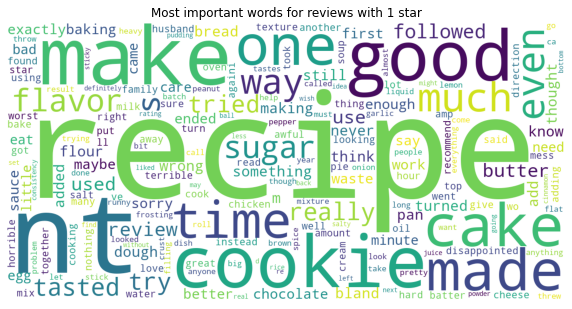

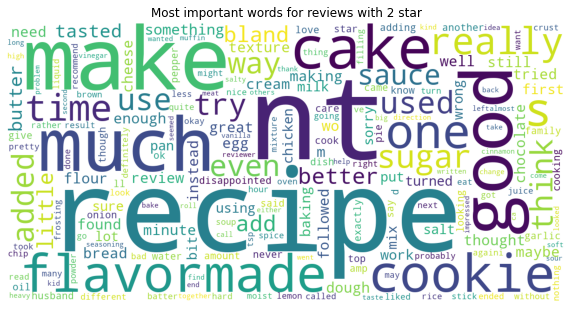

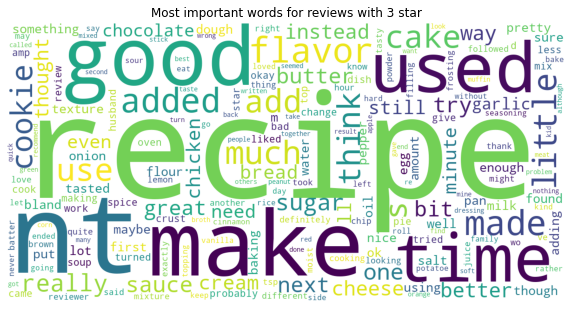

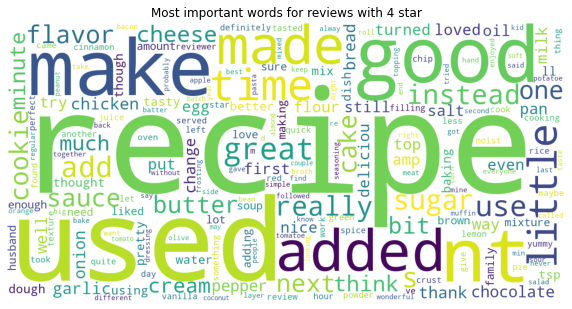

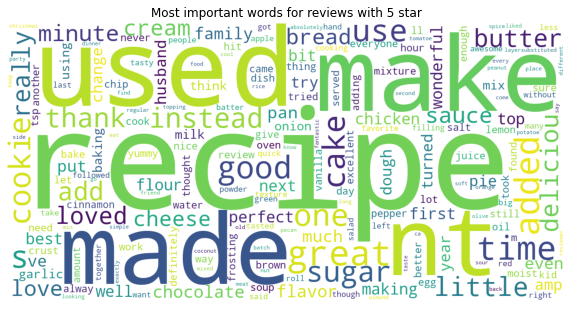

In [52]:
# Generate a word cloud image
for i in range(len(rev_sentiment_level)):
    wordcloud = WordCloud(width = 1200, height = 600, random_state=1, background_color='white', collocations=False, stopwords = STOPWORDS).generate(str_text_coms[i])
    fig = plt.figure(figsize=(10,6))
    plt.imshow(wordcloud)
    plt.title(f"Most important words for reviews with {i+1} star")
    plt.axis('off')
    plt.savefig(f'word_cloud_review{i+1}.png')
    plt.show()

In [53]:
for i in range(len(tf_lists)):
    print(tf_lists[i].most_common(15),"\n")

[('recipe', 2365), ('nt', 1915), ('like', 1241), ('would', 840), ('make', 838), ('good', 664), ('made', 640), ('cake', 621), ('one', 605), ('much', 569), ('even', 547), ('time', 502), ('way', 435), ('s', 432), ('sugar', 432)] 

[('nt', 2110), ('recipe', 1895), ('like', 1208), ('make', 1003), ('would', 941), ('much', 740), ('good', 691), ('made', 629), ('cake', 626), ('flavor', 582), ('s', 533), ('really', 531), ('one', 510), ('sugar', 484), ('time', 453)] 

[('nt', 4320), ('recipe', 4170), ('good', 2636), ('make', 2518), ('would', 2346), ('like', 2323), ('used', 1880), ('made', 1673), ('time', 1604), ('added', 1583), ('flavor', 1565), ('little', 1499), ('also', 1492), ('much', 1470), ('add', 1375)] 

[('recipe', 11820), ('used', 8760), ('good', 8307), ('nt', 7856), ('make', 7406), ('added', 7085), ('made', 6291), ('also', 5623), ('time', 5398), ('little', 4852), ('great', 4845), ('like', 4825), ('would', 4454), ('use', 4267), ('add', 4073)] 

[('recipe', 38274), ('used', 23734), ('made

It can be seen that the words who appears in all of the wordclouds are incredibly similar. It seems like the words used for each reviews of each rating are roughly the same. In order to find more unique words for each rating, we try using probabilistic inverse document frequency instead of inverse document frequency smooth to weight unique words for the universe higher. However the most rated words which appeard in the communities had a raw count of 6, and was mostly spelling mistakes. A read through of 50 random selected reviews of 1 star indicates that the user reviews are quite constructive. 

In general instead of using rough language to describe how "bad" the recipe is, they describe how they did it differently or improved the recipe in their own views. A quick study of a reviews from other ratings, shows this seem to be the case for the other categories as well. This is support by the enhanced words in the wordcloud, with word as "make" "recipe" "much" "used" "added".

In [54]:
reviews_sorted[0][300:350]
reviews_sorted[1][300:350]
reviews_sorted[2][300:350]
reviews_sorted[3][300:350]
reviews_sorted[4][340:350]

["i've used this recipe three times with great results. it took me longer to bake than the recipe suggests but that could be because of my oven. a nice touch is to add a 1/2 a teaspoon of almond extract.",
 "this turned out great. i baked it in a 9x13in pan because the top is my favorite part. it took 35min. to bake. i didn't add any glaze or anything because this stands on its own!",
 "these are delicious.  here's an idea that i use and may be helpful to those who don't want to make a full size recipe.  i mix all the dry ingredients together and then divide them into 4 plastic bags.  when i'm ready to bake a few muffins i spray a mini muffin tin w/ non-stick spray.  add 1 egg, 1/8 cup oil, 1/8 cup water and 1/8 cup lemon juice to the dry mix.  fill cups about 2/3 full and bake 18-20 minutes.  yield: about 14 mini muffins.  perfect for me.",
 'i made this for holiday gifts it was easy and very moist. i already had a almond poppy seed cake so i left out the seeds. for the water part i j

## Discussion

### What went well

This project managed to get a good insights into connections between ingredients in the approximately 40000 recipes. It may not have identified the main ingredients of the different cuisines in the world, but it gave insight in which ingredients are mostly used in baking, western dinner, asian cooking and cocktail. This could be due to the fact the recipes are downloaded from the "western world" part of the platform combined with it is user generated recipes, the result is that it is primarily the "western" take on recipes from the different cuisines of the world. This project also discorvered that the different in sentiment-level between 1 star reviews and 5 star reviews are slim, however ther are more very negative reviews in the lower ratings and more very positive in the higher ratings. An analysis of the words in the reviews of each rating shows that the language used is very similar, which is partly due to the reviews are about the users take on the recipes, what they did different/wrong/got right. Due to the range of similarity scores in the different ratings, it could possibly be used as a measurement to choose between two equally rated recipy for the same dish.

### What could be improved

Overall it would have been better to have worked with a more diverse dataset, if the focus was the worlds cuisines. A more thorough data cleaning would probably also have given a better result relative to this projects goal.

It could also have been advantageous to make the network as a bipartite network where nodes were recipes and ingredients, but because of computing power/time it wasn't possible without reducing the dataset.

## Contributions

All sections was discussed worked on together, however 

Martin Illum (s184286) had the lead role in sections "Reviews and sentiment" and "data-scrape"

Hans Christian Bechsøfft Mikkelsen (s184294) had the lead role in section "Community detection"